# What fraction of reads of each biotype in each tissue?

* get gene reads from rnaseq_qc_agg
* get total reads from rnaseqc/{SAMPLE_ID}.metrics.tsv - not sure which is right?

In [1]:
import pandas as pd
import json
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
# Load JSON data from a file
with open('/home/klawren/oak/gtex/data/other_references/gtex_colors.json', 'r') as file:
    tissue_color_data = json.load(file)

# Convert the JSON data to a DataFrame
tissue_color_df = pd.DataFrame.from_dict(tissue_color_data, orient='index')
tissue_color_df.index.set_names('tissue_name', inplace=True)
tissue_color_df.reset_index(inplace=True)
tissue_color_df['tissue_color_hex'] = '#' + tissue_color_df['tissue_color_hex']
tissue_color_palette = sns.color_palette(tissue_color_df['tissue_color_hex'])

gene_type_pal_highlight = {'new_lncRNA':'#fb83ba',
                            'other_lncRNA':'#b70657',
                            'protein_coding':'#215B30',
                            'other_noncoding_RNA':'#6A5ACD',
                            'pseudogene':'#005BBF', 
                            'artifact':'grey'}

In [94]:
# bring in gencode ids
gencode_ids = pd.read_csv('/home/klawren/oak/gtex/data/other_references/gencode/gencode_id_matching_simplified.txt', sep='\t', index_col=0)
gencode_ids['gene_type_grouped_highlight'] = np.where(gencode_ids['gene_type_grouped_highlight'] == 'CLS_lncRNA', 'new_lncRNA', gencode_ids['gene_type_grouped_highlight'])

# load in tissue-sample matching
sample_meta = pd.read_csv('/home/klawren/oak/gtex/data/other_references/v10/GTEx_Analysis_v10_Annotations_SampleAttributesDS.txt', sep='\t')
passed_samples = sample_meta[sample_meta['SMAFRZE']=='RNASEQ']
tissue_sample_lists = passed_samples.groupby('SMTSD').agg({'SAMPID':'unique'})

tissue_cutoff = 30
# only consider those with more that 30 samples

print(passed_samples.groupby('SMTSD').size()[passed_samples.groupby('SMTSD').size() < tissue_cutoff]) 
large_sample_size_tissues = passed_samples.groupby('SMTSD').size()[passed_samples.groupby('SMTSD').size() > tissue_cutoff].index
print('continuing with {} tissues'.format(len(large_sample_size_tissues)))

tissue_sample_lists = tissue_sample_lists[tissue_sample_lists.index.isin(large_sample_size_tissues)]
passed_samples = passed_samples[passed_samples['SMTSD'].isin(large_sample_size_tissues)]
tissue_color_df = tissue_color_df[tissue_color_df['tissue_name'].isin(large_sample_size_tissues)]
tissue_color_palette = sns.color_palette(tissue_color_df['tissue_color_hex'])

SMTSD
Cervix - Ectocervix                                      24
Cervix - Endocervix                                      23
Colon - Transverse - Mixed Cell                          10
Colon - Transverse - Mucosa                               8
Colon - Transverse - Muscularis                           9
Fallopian Tube                                           29
Kidney - Medulla                                         11
Liver - Hepatocyte                                        9
Liver - Mixed Cell                                        9
Liver - Portal Tract                                      2
Pancreas - Acini                                          9
Pancreas - Islets                                         3
Pancreas - Mixed Cell                                    10
Small Intestine - Terminal Ileum - Lymphoid Aggregate     9
Small Intestine - Terminal Ileum - Mixed Cell            10
Stomach - Mixed Cell                                     29
Stomach - Mucosa                  

/local/scratch/klawren/slrmtmp.48494398/ipykernel_9477/1090913371.py:6: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_meta = pd.read_csv('/home/klawren/oak/gtex/data/other_references/v10/GTEx_Analysis_v10_Annotations_SampleAttributesDS.txt', sep='\t')


get the v10 reads per gene in each tissue

In [110]:
# # takes ~8 minutes
# v10_gene_coutns = pd.read_csv('/home/klawren/oak/gtex/data/other_references/v10/GTEx_Analysis_v10_RNASeQCv2.4.2_gene_reads.gct.gz', skiprows=2, sep='\t')

# v10_tissue_type_counts = []
# for tissue_id, row in tqdm(tissue_sample_lists.iterrows()):
#     v10_gene_coutns[f'{tissue_id}.total_counts'] = v10_gene_coutns[row['SAMPID']].sum(axis=1)

# v10_tissue_gene_counts = v10_gene_coutns[['Name', *[f'{tissue_id}.total_counts' for tissue_id in tissue_sample_lists.index.values]]]
# v10_tissue_gene_counts.to_csv('/home/klawren/oak/gtex/data/other_references/v10/GTEx_Analysis_v10_tissue_gene_reads.txt', sep='\t', index=None)

v10_tissue_gene_counts = pd.read_csv('/home/klawren/oak/gtex/data/other_references/v10/GTEx_Analysis_v10_tissue_gene_reads.txt', sep='\t')

get the v11 reads per gene in each tissue

In [ ]:
# count the number of reads in each tissue for each gene
tissue_type_counts = []
for tissue_id in tqdm(tissue_sample_lists.index.values, total=len(tissue_sample_lists)):
    print(tissue_id)
    tissue_id_clean = tissue_id.replace(' - ', '_').replace('-', '_').replace(' ', '_').replace('(', '').replace(')', '')
    tissue_agg = pd.read_csv(f'{rnaseqc_dir}/rnaseqc_agg/{tissue_id_clean}.v11.gene_reads.gct.gz', sep='\t')
    tissue_agg[f'{tissue_id}.total_counts'] = tissue_agg[tissue_agg.columns[2:]].sum(axis=1)
    tissue_type_counts.append(tissue_agg[['Name', f'{tissue_id}.total_counts']])

# concatenate the tissues
v11_tissue_gene_counts = tissue_type_counts[0].reset_index()
for idx in range(len(tissue_type_counts)-1):
    v11_tissue_gene_counts = pd.merge(v11_tissue_gene_counts, tissue_type_counts[idx+1], on=['Name'])


  0%|          | 0/50 [00:00<?, ?it/s]

Adipose - Subcutaneous
Adipose - Visceral (Omentum)
Adrenal Gland
Artery - Aorta
Artery - Coronary
Artery - Tibial
Bladder
Brain - Amygdala
Brain - Anterior cingulate cortex (BA24)
Brain - Caudate (basal ganglia)
Brain - Cerebellar Hemisphere
Brain - Cerebellum
Brain - Cortex
Brain - Frontal Cortex (BA9)
Brain - Hippocampus
Brain - Hypothalamus
Brain - Nucleus accumbens (basal ganglia)
Brain - Putamen (basal ganglia)
Brain - Spinal cord (cervical c-1)
Brain - Substantia nigra
Breast - Mammary Tissue
Cells - Cultured fibroblasts
Cells - EBV-transformed lymphocytes
Colon - Sigmoid
Colon - Transverse
Esophagus - Gastroesophageal Junction
Esophagus - Mucosa
Esophagus - Muscularis
Heart - Atrial Appendage
Heart - Left Ventricle
Kidney - Cortex
Liver
Lung
Minor Salivary Gland
Muscle - Skeletal
Nerve - Tibial
Ovary
Pancreas
Pituitary
Prostate
Skin - Not Sun Exposed (Suprapubic)
Skin - Sun Exposed (Lower leg)
Small Intestine - Terminal Ileum
Spleen
Stomach
Testis
Thyroid
Uterus
Vagina
Whole Bl

In [166]:
tissue_gene_counts = pd.merge(v11_tissue_gene_counts, gencode_ids, left_on='Name', right_on='gene_id_v47', how='right', suffixes=['_v11', ''])
tissue_gene_counts = pd.merge(v10_tissue_gene_counts, tissue_gene_counts, left_on='Name', right_on='gene_id_v39', how='right', suffixes=['_v10', '_v11'])
tissue_gene_counts.columns

Index(['Name_v10', 'Adipose - Subcutaneous.total_counts_v10',
       'Adipose - Visceral (Omentum).total_counts_v10',
       'Adrenal Gland.total_counts_v10', 'Artery - Aorta.total_counts_v10',
       'Artery - Coronary.total_counts_v10',
       'Artery - Tibial.total_counts_v10', 'Bladder.total_counts_v10',
       'Brain - Amygdala.total_counts_v10',
       'Brain - Anterior cingulate cortex (BA24).total_counts_v10',
       ...
       'gene_type_grouped', 'gene_type_grouped_highlight', 'in_v47_full',
       'in_v47_collapsed', 'in_v39_full', 'in_v39_collapsed',
       'collapsed_location_change_v47', 'collapsed_location_change_v39',
       'collapsed_location_change_between_versions',
       'full_location_change_between_versions'],
      dtype='object', length=115)

In [168]:
tissue_gene_counts[[f'{tissue_id}.total_counts_v10' for tissue_id in tissue_sample_lists.index.values]].sum()

Adipose - Subcutaneous.total_counts_v10                       4.731534e+10
Adipose - Visceral (Omentum).total_counts_v10                 3.782510e+10
Adrenal Gland.total_counts_v10                                1.950451e+10
Artery - Aorta.total_counts_v10                               3.026246e+10
Artery - Coronary.total_counts_v10                            1.758780e+10
Artery - Tibial.total_counts_v10                              4.645618e+10
Bladder.total_counts_v10                                      5.818282e+09
Brain - Amygdala.total_counts_v10                             1.168552e+10
Brain - Anterior cingulate cortex (BA24).total_counts_v10     1.639423e+10
Brain - Caudate (basal ganglia).total_counts_v10              2.109757e+10
Brain - Cerebellar Hemisphere.total_counts_v10                1.876368e+10
Brain - Cerebellum.total_counts_v10                           1.584691e+10
Brain - Cortex.total_counts_v10                               1.861749e+10
Brain - Frontal Cortex (B

In [169]:
tissue_gene_counts[[f'{tissue_id}.total_counts_v11' for tissue_id in tissue_sample_lists.index.values]].sum()

Adipose - Subcutaneous.total_counts_v11                       4.634773e+10
Adipose - Visceral (Omentum).total_counts_v11                 3.700901e+10
Adrenal Gland.total_counts_v11                                1.918494e+10
Artery - Aorta.total_counts_v11                               2.964489e+10
Artery - Coronary.total_counts_v11                            1.723002e+10
Artery - Tibial.total_counts_v11                              4.560482e+10
Bladder.total_counts_v11                                      5.707601e+09
Brain - Amygdala.total_counts_v11                             1.154326e+10
Brain - Anterior cingulate cortex (BA24).total_counts_v11     1.620025e+10
Brain - Caudate (basal ganglia).total_counts_v11              2.085575e+10
Brain - Cerebellar Hemisphere.total_counts_v11                1.855771e+10
Brain - Cerebellum.total_counts_v11                           1.567959e+10
Brain - Cortex.total_counts_v11                               1.838620e+10
Brain - Frontal Cortex (B

In [135]:
tissue_gene_counts.groupby(['in_v47_collapsed', 'in_v47_full', 'in_v39_collapsed', 'in_v39_full']).agg({'Adipose - Subcutaneous.total_counts_v11':'sum',
    'Adipose - Subcutaneous.total_counts_v10':'sum'})


Adipose - Subcutaneous.total_counts_v11  \
in_v47_collapsed in_v47_full in_v39_collapsed in_v39_full                                            
False            False       False            True                                    0.000000e+00   
                             True             True                                    0.000000e+00   
                 True        False            False                                   0.000000e+00   
                                              True                                    0.000000e+00   
                             True             True                                    0.000000e+00   
True             True        False            False                                   1.897602e+08   
                                              True                                    5.955163e+06   
                             True             True                                    4.615201e+10   

                                                           Adipose - Subcutaneous.total_counts_v10  
in_v47_collapsed in_v47_full in_v39_collapsed in_v39_full                                           
False            False       False            True                                    0.000000e+00  
                             True             True                                    5.830050e+07  
                 True        False            False                                   0.000000e+00  
                                              True                                    0.000000e+00  
                             True             True                                    8.982617e+07  
True             True        False            False                                   0.000000e+00  
                                              True                                    0.000000e+00  
                             True             True                                    4.716721e+10

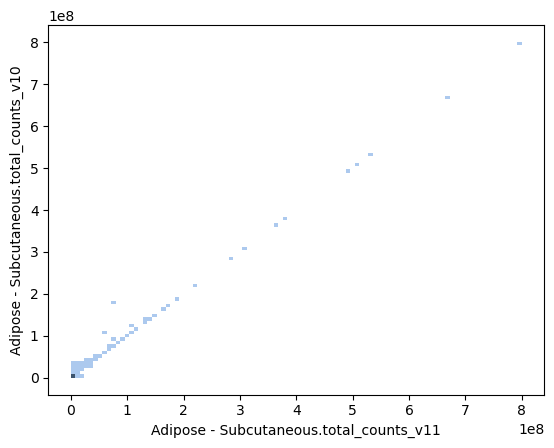

In [124]:
ax = sns.histplot(tissue_gene_counts, x='Adipose - Subcutaneous.total_counts_v11', y='Adipose - Subcutaneous.total_counts_v10', bins=100)


In [87]:
# concatenate the tissues
tissue_type_counts_merged = tissue_type_counts[0].reset_index()
for idx in range(len(tissue_type_counts)-1):
    tissue_type_counts_merged = pd.merge(tissue_type_counts_merged, tissue_type_counts[idx+1], on=['in_v47_full', 'in_v47_collapsed', 'in_v39_full', 'in_v39_collapsed'])
tissue_type_counts_merged['new_type'] = np.where(tissue_type_counts_merged['in_v39_full'], np.where(tissue_type_counts_merged['in_v39_collapsed'], 'old_v39', 'new_in collapse'), 'new_v47')

tissue_type_counts_merged = tissue_type_counts_merged.set_index('new_type').drop(columns=['in_v47_full', 'in_v47_collapsed', 'in_v39_full', 'in_v39_collapsed'])

# calcualte the fraction of total reads for each
new_types = ['old_v39', 'new_in collapse', 'new_v47']
tissue_type_counts_merged = tissue_type_counts_merged.T
tissue_type_counts_merged['total'] = tissue_type_counts_merged.sum(axis=1)
tissue_type_counts_merged['tissue_id'] = tissue_type_counts_merged.index.str.split('.total_counts').str[0]

for gene_type in new_types:
    tissue_type_counts_merged[f'{gene_type}_fraction'] = tissue_type_counts_merged[f'{gene_type}'] / tissue_type_counts_merged['total']

tissue_type_counts_melt = tissue_type_counts_merged.melt(id_vars='tissue_id', value_vars=[f'{gene_type}_fraction' for gene_type in new_types], value_name='fraction_counts')
tissue_type_counts_melt['gene_type'] = tissue_type_counts_melt['new_type'].str.split('_fraction').str[0]

<Axes: ylabel='fraction_counts'>

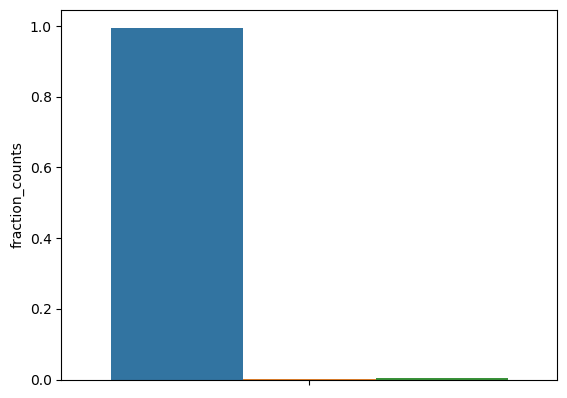

In [88]:
sns.barplot(tissue_type_counts_melt, y='fraction_counts', legend=False, hue='gene_type')

In [ ]:
pd.read_csv (/home/klawren/oak/gtex/data/other_references/v10/GTEx_Analysis_v10_RNASeQCv2.4.2_gene_reads.gct.gz)

/local/scratch/klawren/slrmtmp.48494398/ipykernel_9477/4045542416.py:27: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


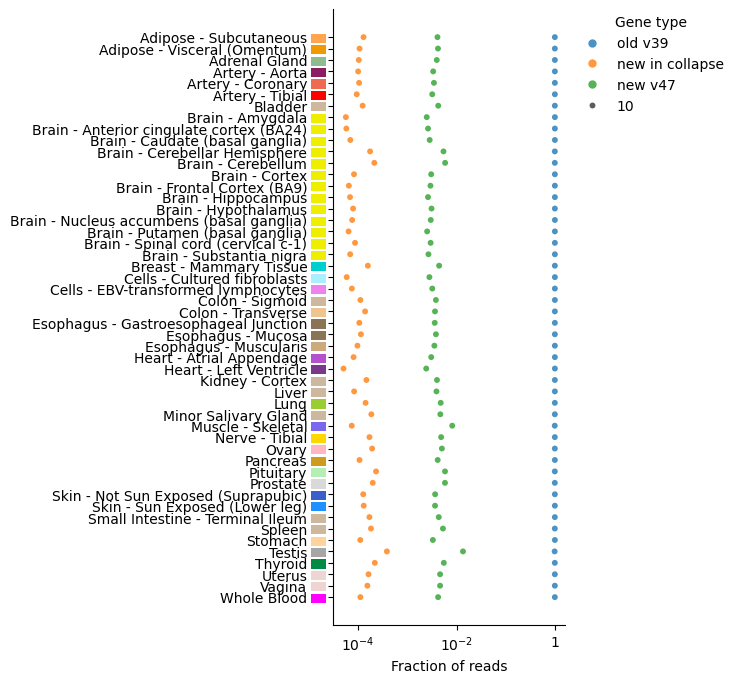

In [79]:
fig, ax = plt.subplots(figsize=(3,8))

sns.scatterplot(tissue_type_counts_melt, y='tissue_id', x='fraction_counts', hue='gene_type', ax=ax, size=10, alpha=.8, ec='none')
ax.set_ylabel('')
ax.set_xlabel('Fraction of reads')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.01), frameon=False, title='Gene type')
legend = ax.get_legend()
new_labels = ['{}'.format(label.get_text().replace('_', ' ')) for label in legend.texts]
for t, new_label in zip(legend.texts, new_labels):
    t.set_text(new_label)


# Add circles on the left side of the y-axis
for index, row in tissue_color_df.iterrows():
    tissue_id = row['tissue_name']
    color = row['tissue_color_hex']
    # Get the y position for the tissue_id
    y_position = tissue_type_counts_melt[tissue_type_counts_melt['tissue_id'] == tissue_id].index[0]
    # Create a circle
    ax.add_patch(patches.Rectangle((ax.get_xlim()[0]-.45, y_position-.3), width=.3, height=.8, color=color, ec='none', clip_on=False))

ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(axis='y', which='major', pad=15)

ax.set_xticks([-4, -2, 0], labels=['$10^{-4}$', '$10^{-2}$', '1'])
plt.tight_layout()


/home/klawren/.pixi/envs/python/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/klawren/.pixi/envs/python/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 12.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/klawren/.pixi/envs/python/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 74.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/local/scratch/klawren/slrmtmp.48494398/ipykernel_9477/3911373317.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['new lncRNA', 'pseudogene', 'existing lncRNA', 'pro

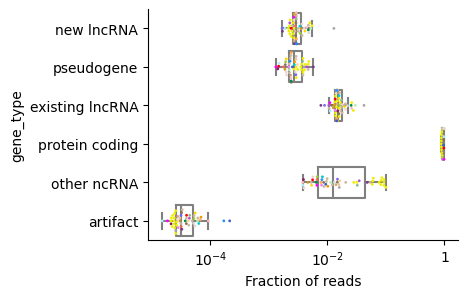

In [35]:
fig, ax = plt.subplots(figsize=(4,3))

sns.boxplot(tissue_type_counts_melt, x='fraction_counts', y='gene_type', legend=None, color='grey', fill=False, fliersize=0, ax=ax)
sns.swarmplot(tissue_type_counts_melt, hue='tissue_id', x='fraction_counts', y='gene_type', palette=tissue_color_palette, s=2, legend=None, ax=ax)

ax.spines[['top', 'right']].set_visible(False)
ax.set_xticks([-4, -2, 0], labels=['$10^{-4}$', '$10^{-2}$', '1'])
ax.set_xlabel('Fraction of reads')

ax.set_yticklabels(['new lncRNA', 'pseudogene', 'existing lncRNA', 'protein coding', 'other ncRNA', 'artifact'])
plt.show()

In [37]:
gencode_ids[gencode_ids['gene_id_v39'].isna()]['gene_type_grouped_highlight'].value_counts()

gene_type_grouped_highlight
new_lncRNA             18307
protein_coding           115
pseudogene                38
other_noncoding_RNA        3
Name: count, dtype: int64

show how the new reference has reads that map to the new exons (genes in v47 not in v39)
show also that some reads decrease becuase of ambiguous mapping (genes in v39 not in v47)

In [38]:
# get the total number of reads in each sample
rnaseqc_dir = '/home/klawren/oak/gtex/output/all_tissues'
sample_total_reads = pd.DataFrame(tissue_sample_lists.explode('SAMPID')).reset_index().set_index('SAMPID')



for sample_id, row in tqdm(sample_total_reads.iterrows(), total=len(sample_total_reads)):
    sample_metrics = pd.read_csv(f'{rnaseqc_dir}/rnaseq_qc/{sample_id}.metrics.tsv', sep='\t').set_index('Sample')
    # the reads in the gene_counts.tpm are from high quality, exonic reads (multiply rate by total)
    sample_total_reads.loc[sample_id, 'total_reads']  = sample_metrics.loc['High Quality Reads'].iloc[0]
    sample_total_reads.loc[sample_id, 'exon_rate']  = sample_metrics.loc['High Quality Exonic Rate'].iloc[0]
    sample_total_reads.loc[sample_id, 'total_exon_reads'] = sample_metrics.loc['High Quality Reads'].iloc[0] * sample_metrics.loc['High Quality Exonic Rate'].iloc[0]

sample_total_reads.to_csv("/home/klawren/oak/gtex/output/all_tissues/rnaseqc_agg/sample_total_reads.txt", sep='\t')

  0%|          | 0/19529 [00:00<?, ?it/s]

In [ ]:
for gene_type in gencode_ids.gene_type_grouped_highlight.unique():
    tissue_type_counts_merged[f'{gene_type}_fraction'] = np.log10(tissue_type_counts_merged[f'{gene_type}'] / tissue_type_counts_merged['total'])


gene_type_grouped_highlight,artifact,new_lncRNA,other_lncRNA,other_noncoding_RNA,protein_coding,pseudogene,total,tissue_id,new_lncRNA_fraction,pseudogene_fraction,other_lncRNA_fraction,protein_coding_fraction,other_noncoding_RNA_fraction,artifact_fraction
Adipose - Subcutaneous.total_counts,3101796,136569755,665604106,358215901,45072520692,111715679,46347727929,Adipose - Subcutaneous,-2.530674,-2.617914,-1.842812,-0.012117,-2.111884,-4.174415
Adipose - Visceral (Omentum).total_counts,2553938,100549033,487725879,376005742,35940528498,101649754,37009012844,Adipose - Visceral (Omentum),-2.565930,-2.561201,-1.880132,-0.012723,-1.993113,-4.161097
Adrenal Gland.total_counts,848618,56110327,333756550,621227385,18100937696,72064077,19184944653,Adrenal Gland,-2.533918,-2.425242,-1.759531,-0.025259,-1.489710,-4.354248
Artery - Aorta.total_counts,629723,81935147,443332440,115643292,28961264588,42082437,29644887627,Artery - Aorta,-2.558480,-2.847849,-1.825220,-0.010132,-2.408829,-4.672800
Artery - Coronary.total_counts,544971,48686115,258280472,114462353,16777485918,30563836,17230023665,Artery - Coronary,-2.548881,-2.751078,-1.824194,-0.011559,-2.177623,-4.499912
Artery - Tibial.total_counts,1783351,109775223,620125324,254415845,44551802561,66920243,45604822547,Artery - Tibial,-2.618506,-2.833453,-1.866531,-0.010145,-2.253467,-4.407774
Bladder.total_counts,299588,18149275,100075140,54912763,5521521121,12642663,5707600550,Bladder,-2.497594,-2.654615,-1.756127,-0.014395,-2.016780,-4.279929
Brain - Amygdala.total_counts,248185,24696023,153959524,1156220554,10164068818,44065080,11543258184,Brain - Amygdala,-2.669701,-2.418234,-1.874922,-0.055261,-0.999288,-4.667553
Brain - Anterior cingulate cortex (BA24).total_counts,343082,36442295,231272035,1328190647,14545152614,58847985,16200248658,Brain - Anterior cingulate cortex (BA24),-2.647916,-2.439790,-1.845399,-0.046803,-1.086261,-4.674124
Brain - Caudate (basal ganglia).total_counts,503277,50471562,309883368,1738069508,18658840408,97980091,20855748214,Brain - Caudate (basal ganglia),-2.616179,-2.328088,-1.828028,-0.048341,-1.079159,-4.617419
